In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Lambda, Compose, Normalize
from collections import defaultdict
from torch.utils.data import random_split
import copy

from NN_utils import *
from NN_utils.train_and_eval import *
from uncertainty import train_NN_with_g
from uncertainty.losses import penalized_uncertainty
import uncertainty.comparison as unc_comp
import uncertainty.quantifications as unc


from torch.utils.data import random_split

In [2]:
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

True


In [3]:
transforms_train = transforms.Compose([
                    transforms.RandomCrop(32, padding=4),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
transforms_ = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

In [4]:
training_data = datasets.CIFAR10(
root="data",
 train=True,
 download=True,
transform=transforms_train)

test_data = datasets.CIFAR10(
root="data",
train=False,
download=True,
transform=transforms_)

train_size = int(0.5*len(training_data))
val_size = len(training_data) - train_size
training_data, validation_data = random_split(training_data, [train_size, val_size])

Files already downloaded and verified
Files already downloaded and verified


In [5]:
batch_size = 12
train_dataloader = DataLoader(training_data, batch_size=batch_size,shuffle = True)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size,shuffle = True)
test_dataloader = DataLoader(test_data, batch_size=12)

In [6]:
from NN_models.CIFAR10 import Model_CNN_10_with_g as Model_CNN_with_g
model = Model_CNN_with_g()

In [7]:
def model_metrics(model,data):
    loss_criterion = nn.NLLLoss(reduction = 'sum')
    model.eval()
    dev = next(model.parameters()).device
    total = 0
    correct= 0
    g_i = 0
    bce = 0
    with torch.no_grad():
        for image,label in data:
            image,label = image.to(dev), label.to(dev)
            output = model(image)
            g = model.get_g()
            total += label.size(0)
            correct += correct_total(output,label)
            g_i += torch.sum(g).item()
            bce += loss_criterion(output,label).item()

    return (correct/total),g_i/total, bce/total

In [8]:
loss_criterion = nn.NLLLoss(reduction = 'none')
loss_fn = penalized_uncertainty(loss_criterion,np.log(10))

In [9]:
model = Model_CNN_with_g()
model = model.to(dev)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

loss_criterion = nn.NLLLoss(reduction = 'none')
loss_fn = penalized_uncertainty(loss_criterion,np.log(10))

model_trainer = Trainer(model,optimizer,loss_fn, print_loss = True,keep_hist = True)
model_trainer.fit(train_dataloader,80)
acc, g, bce = model_metrics(model,train_dataloader)
print('Conjunto de treinamento: acc = ', acc, 'média de g = ', g, 'média de bce = ', bce, '\n')
acc, g, bce = model_metrics(model,test_dataloader)
print('Conjunto de teste: acc = ', acc, 'média de g = ', g, 'média de bce = ', bce, '\n')

Epoch  1 , loss =  2.2969778027964645
Epoch  1 , loss =  2.242379144491939
Epoch  1 , loss =  2.0442711534747233
Epoch  1 , loss =  1.8171785184380647
Epoch  1 , loss =  1.6817909822926183
Epoch  1 , loss =  1.586351747132995
Epoch  1 , loss =  1.504117070255719
Epoch  1 , loss =  1.434191603435207
Epoch  1 , loss =  1.3678374166909655
Epoch  1 , loss =  1.3004199916250188
Epoch  1 , loss =  1.2367620935195238
Epoch  1 , loss =  1.1815279366416345
Epoch  1 , loss =  1.1224039039233138
Epoch  1 , loss =  1.0815830024213113
Epoch  1 , loss =  1.0340022578578079
Epoch  1 , loss =  0.9926005614896425
Epoch  1 , loss =  0.9654178442630109
Epoch  1 , loss =  0.930507403775163
Epoch  1 , loss =  0.9140248371005745
Epoch  1 , loss =  0.8801979319605397
Epoch  1 , loss =  0.85444484924229
Epoch  1 , loss =  0.8341266450806452
Epoch  1 , loss =  0.8170168685178039
Epoch  1 , loss =  0.7928662961509773
Epoch  1 , loss =  0.780243597252584
Epoch  1 , loss =  0.7629155822012452
Epoch  1 , loss =  0

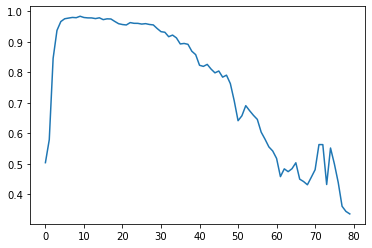

In [10]:
plt.plot(model_trainer.g_list)

In [11]:
model_3 = Model_CNN_with_g()
model_3 = model_3.to(dev)
optimizer = torch.optim.SGD(model_3.parameters(), lr=1e-3)
loss_fn = penalized_uncertainty(loss_criterion,np.log(10))

model_trainer_3 = Trainer(model_3,optimizer,loss_fn, print_loss = True,keep_hist = True)
model_trainer_3.fit_x(train_dataloader,40)
model_trainer_3.fit_g(validation_dataloader,40)

acc, g, bce = model_metrics(model_3,train_dataloader)
print('Conjunto de treinamento: acc = ', acc, 'média de g = ', g, 'média de bce = ', bce, '\n')
acc, g, bce = model_metrics(model_3,test_dataloader)
print('Conjunto de teste: acc = ', acc, 'média de g = ', g, 'média de bce = ', bce, '\n')

Epoch  1 , loss =  2.2411674056881448
Epoch  1 , loss =  1.9969223347025962
Epoch  1 , loss =  1.7880079753110596
Epoch  1 , loss =  1.6555332804595668
Epoch  1 , loss =  1.554354215251736
Epoch  1 , loss =  1.468805257281049
Epoch  1 , loss =  1.3937483433912903
Epoch  1 , loss =  1.3318818399178547
Epoch  1 , loss =  1.2594859286027311
Epoch  1 , loss =  1.1944273173265632
Epoch  1 , loss =  1.1366048776857456
Epoch  1 , loss =  1.0887488036661368
Epoch  1 , loss =  1.0502224818958887
Epoch  1 , loss =  1.0073739499883323
Epoch  1 , loss =  0.9776214023483577
Epoch  1 , loss =  0.9484973094013167
Epoch  1 , loss =  0.9191503372479538
Epoch  1 , loss =  0.884717461458209
Epoch  1 , loss =  0.8686741437841629
Epoch  1 , loss =  0.8479361147146078
Epoch  1 , loss =  0.8236277138782154
Epoch  1 , loss =  0.8052293620896374
Epoch  1 , loss =  0.7830426204670757
Epoch  1 , loss =  0.7689912888237531
Epoch  1 , loss =  0.7564737593644297
Epoch  1 , loss =  0.7383416632508534
Epoch  1 , loss

In [12]:
model_4 = Model_CNN_with_g()
model_4 = model_4.to(dev)
optimizer = torch.optim.SGD(model_4.parameters(), lr=1e-3)
loss_fn = penalized_uncertainty(loss_criterion,np.log(10))

model_trainer_4 = Trainer(model_4,optimizer,loss_fn, print_loss = True,keep_hist = True)
model_trainer_4.fit_x(train_dataloader,1)
model_trainer_4.fit_g(validation_dataloader,40)

acc, g, bce = model_metrics(model_4,train_dataloader)
print('Conjunto de treinamento: acc = ', acc, 'média de g = ', g, 'média de bce = ', bce, '\n')
acc, g, bce = model_metrics(model_4,test_dataloader)
print('Conjunto de teste: acc = ', acc, 'média de g = ', g, 'média de bce = ', bce, '\n')

Epoch  1 , loss =  2.247856280339199
Epoch  1 , loss =  2.0941144880658147
Epoch  1 , loss =  2.0970608383245524
Epoch  1 , loss =  2.0986291869702587
Epoch  1 , loss =  2.096699533158209
Epoch  1 , loss =  2.096144236495536
Epoch  1 , loss =  2.0927744583296457
Epoch  1 , loss =  2.1000526421587207
Epoch  1 , loss =  2.09734251019822
Epoch  1 , loss =  2.0976599226643167
Epoch  1 , loss =  2.0976471858038326
Epoch  1 , loss =  2.095453134539489
Epoch  1 , loss =  2.0959862404844354
Epoch  1 , loss =  2.095530459096015
Epoch  1 , loss =  2.0942412049665102
Epoch  1 , loss =  2.094941950862559
Epoch  1 , loss =  2.093871176185626
Epoch  1 , loss =  2.0941587374214934
Epoch  1 , loss =  2.09601114510117
Epoch  1 , loss =  2.0952216861572923
Epoch  1 , loss =  2.096086929375288
Epoch  1 , loss =  2.094855044601975
Epoch  1 , loss =  2.0987481905608627
Epoch  1 , loss =  2.09534928625925
Epoch  1 , loss =  2.0965114148358697
Epoch  1 , loss =  2.0966270934368505
Epoch  1 , loss =  2.097517

In [13]:
acc, g, bce = model_metrics(model_4,train_dataloader)
print('Conjunto de treinamento: acc = ', acc, 'média de g = ', g, 'média de bce = ', bce, '\n')
acc, g, bce = model_metrics(model_4,test_dataloader)
print('Conjunto de teste: acc = ', acc, 'média de g = ', g, 'média de bce = ', bce, '\n')

Conjunto de treinamento: acc =  0.2322 média de g =  0.4877837809753418 média de bce =  2.0944531643295288 

Conjunto de teste: acc =  0.2431 média de g =  0.5009750723600388 média de bce =  2.0865321043014524 



In [14]:
model_2 = Model_CNN_with_g()
model_2 = model_2.to(dev)
optimizer = torch.optim.SGD(model_2.parameters(), lr=1e-3)
loss_fn = penalized_uncertainty(loss_criterion,np.log(10))

model_trainer_2 = Trainer(model_2,optimizer,loss_fn, print_loss = True,keep_hist = True)
model_trainer_2.fit_x(train_dataloader,40)
model_trainer_2.fit_g(train_dataloader,40)

acc, g, bce = model_metrics(model_2,train_dataloader)
print('Conjunto de treinamento: acc = ', acc, 'média de g = ', g, 'média de bce = ', bce, '\n')
acc, g, bce = model_metrics(model_2,test_dataloader)
print('Conjunto de teste: acc = ', acc, 'média de g = ', g, 'média de bce = ', bce, '\n')

Epoch  1 , loss =  2.248564677595406
Epoch  1 , loss =  2.001881860954519
Epoch  1 , loss =  1.7933817044215101
Epoch  1 , loss =  1.6686449489071822
Epoch  1 , loss =  1.5694906999305205
Epoch  1 , loss =  1.4799095298415639
Epoch  1 , loss =  1.4061567976698994
Epoch  1 , loss =  1.33030879202937
Epoch  1 , loss =  1.2610126028334339
Epoch  1 , loss =  1.190435975103598
Epoch  1 , loss =  1.141828729157942
Epoch  1 , loss =  1.085711258458199
Epoch  1 , loss =  1.0426982751048228
Epoch  1 , loss =  1.004573365970159
Epoch  1 , loss =  0.9658204994223397
Epoch  1 , loss =  0.9356110652268733
Epoch  1 , loss =  0.9015788248813427
Epoch  1 , loss =  0.8784583278801185
Epoch  1 , loss =  0.8585403390772168
Epoch  1 , loss =  0.8385938523469525
Epoch  1 , loss =  0.8126199284922367
Epoch  1 , loss =  0.7972766857901713
Epoch  1 , loss =  0.7762802217420255
Epoch  1 , loss =  0.757218562674328
Epoch  1 , loss =  0.7442484216410631
Epoch  1 , loss =  0.7267912060608677
Epoch  1 , loss =  0.

In [15]:
model_trainer_2.loss_fn.L0

0.4665627036035061

In [16]:
for image,label in test_dataloader:
    image,label = image.to(dev),label.to(dev)
    output = model_3(image)
    g = model_3.get_g().cpu().detach().numpy().reshape(-1)
    break

(array([1., 2., 2., 1., 0., 0., 1., 0., 2., 3.]),
 array([0.2440771 , 0.31793162, 0.39178616, 0.4656407 , 0.5394952 ,
        0.61334974, 0.68720424, 0.7610588 , 0.8349133 , 0.9087679 ,
        0.9826224 ], dtype=float32),
 <BarContainer object of 10 artists>)

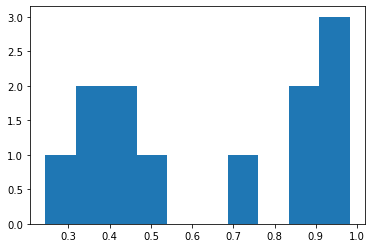

In [17]:
plt.hist(g)

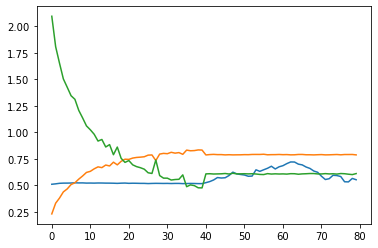

In [18]:
plt.plot(model_trainer_3.g_list)
plt.plot(model_trainer_3.acc_list)
plt.plot(model_trainer_3.bce_list)

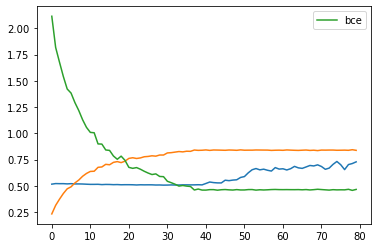

In [19]:
plt.plot(model_trainer_2.g_list)
plt.plot(model_trainer_2.acc_list)
plt.plot(model_trainer_2.bce_list,label = 'bce')
plt.legend()

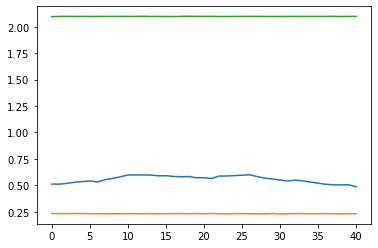

In [20]:
plt.plot(model_trainer_4.g_list)
plt.plot(model_trainer_4.acc_list)
plt.plot(model_trainer_4.bce_list)

In [28]:

uncertainties = ['MCP']

for uncertainty in uncertainties:
    acc_list = []
        
    model_3.eval()
    total = 0
    correct= 0
    mcp_list = []
    g_list = []
    output_list = torch.Tensor([]).to(dev)
    label_list = torch.Tensor([]).to(dev)
    for image,label in validation_dataloader:
        image,label = image.to(dev), label.to(dev)
        
        label_list = torch.cat((label_list,label))
        output = torch.exp(model_3(image))
        output_list = torch.cat((output_list,output))

        uncer = unc.MCP_unc(output).tolist()
        mcp_list.extend(uncer)

        uncer = (1-model_3.get_g().view(-1)).tolist()
        g_list.extend(uncer)

        #uncer = 1-model_3.get_g()
    mcp_list = torch.Tensor(mcp_list)
        

    g_list = torch.Tensor(g_list)
            
            
        
g_list = g_list.view(-1)

In [22]:
g_list = g_list.view(-1)

In [23]:
acc_list_mcp = []
acc_list_g = []
for c in np.arange(0,1,0.05):
    dk_mcp = unc_comp.dontknow_mask(output_list,uncertainty = mcp_list, coverage = c)
    dk_mcp = dk_mcp.to(dev)
    dk_g = unc_comp.dontknow_mask(output_list,uncertainty = g_list, coverage = c)
    dk_g = dk_g.to(dev)
    
    output, label = apply_mask(output_list,label_list,1-dk_mcp)
    correct = correct_total(output,label)
    total = output.size(0)

    acc_list_mcp.append(correct*100/total)

    output, label = apply_mask(output_list,label_list,1-dk_g)
    correct = correct_total(output,label)
    total = output.size(0)
    
    acc_list_g.append(correct*100/total)
    
    

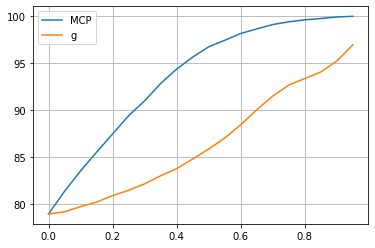

In [24]:
plt.plot( np.arange(0,1,0.05),acc_list_mcp,label = 'MCP')
plt.plot( np.arange(0,1,0.05),acc_list_g, label = 'g')
plt.legend()
plt.grid()
plt.show()

(array([2410., 2187., 1843., 1678., 1696., 2186., 3486., 5661., 3661.,
         192.]),
 array([4.45902348e-04, 8.47466707e-02, 1.69047439e-01, 2.53348207e-01,
        3.37648976e-01, 4.21949744e-01, 5.06250513e-01, 5.90551281e-01,
        6.74852049e-01, 7.59152818e-01, 8.43453586e-01]),
 <BarContainer object of 10 artists>)

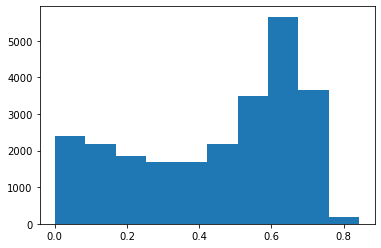

In [25]:
plt.hist(g_list.view(-1).tolist())

In [26]:
g_list.shape

torch.Size([25000])